<a href="https://colab.research.google.com/github/NiteeshSingh/DS-303-Course-Project/blob/main/FNN_and_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries
import pandas as pd

import numpy as np
from numpy import array

from sklearn.metrics import mean_squared_error

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import random as rn

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

### Data Preparation

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DS303/Project/Data/TCS.NS.csv")

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,1341.150024,1347.400024,1317.500000,1322.800049,1222.738525,1351760
1,2018-01-02,1330.000000,1334.800049,1310.099976,1315.599976,1216.082764,1920290
2,2018-01-03,1316.000000,1334.500000,1315.599976,1319.324951,1219.526367,1257120
3,2018-01-04,1325.000000,1331.000000,1320.000000,1328.550049,1228.053223,913082
4,2018-01-05,1325.000000,1349.750000,1325.000000,1344.599976,1242.889282,1153706


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1068 non-null   object 
 1   Open       1068 non-null   float64
 2   High       1068 non-null   float64
 3   Low        1068 non-null   float64
 4   Close      1068 non-null   float64
 5   Adj Close  1068 non-null   float64
 6   Volume     1068 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 58.5+ KB


lets visualise this stock using simple OHLC plot


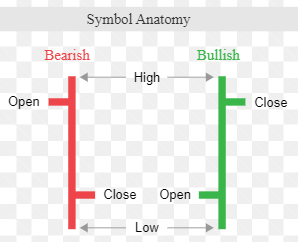

In [ ]:
fig = go.Figure(data=[go.Ohlc(x=data.Date,
                          open=data.Open, high=data.High,
                          low=data.Low, close=data.Close)])
fig.update_layout(
    title = "simple OHLC chart",
    yaxis_title = "stock price"
)
fig.show()

we are going to predict closing price of our stock

so our dependent variable is closing price

In [ ]:
#making date as pandas datetime object
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1068 entries, 2018-01-01 to 2022-04-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1068 non-null   float64
 1   High       1068 non-null   float64
 2   Low        1068 non-null   float64
 3   Close      1068 non-null   float64
 4   Adj Close  1068 non-null   float64
 5   Volume     1068 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 58.4 KB


Lets look at our closing price data over time

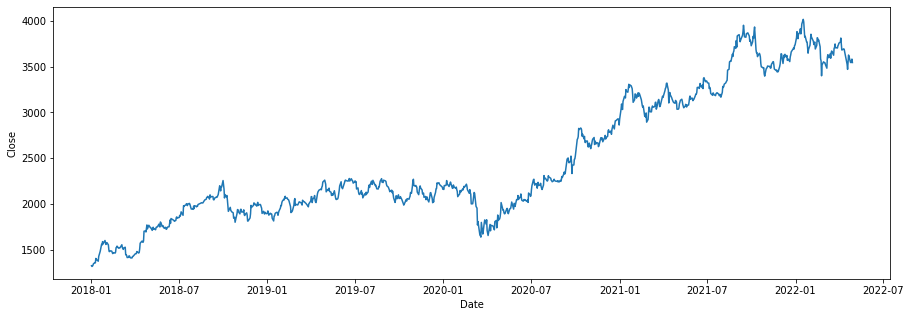

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x=data.index, y=data.Close)

It can be seen from graph that our time series is not stationary with time it has somewhat upward trend

it has property which vary over time

so for prediction purposes we will make our time series stationary by taking %change.

% change = (value at (t) - value at (t-1))/(value at (t-1))

t = time step (here t represent a date and t-1 represent previous date)

In [ ]:
#making each column stationary w.r.t time 
for column in data.columns:
  data[column] = (data[column]-data[column].shift(1))/data[column].shift(1)

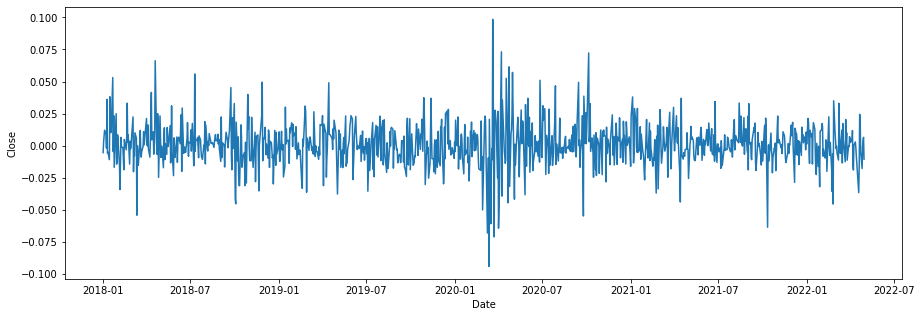

In [ ]:
#lets now plot our closing price variable
plt.figure(figsize=(15,5))
sns.lineplot(x=data.index, y=data.Close)

In [ ]:
data.dropna(axis=0, inplace=True)

lets check the stationarity of our data using dicky fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

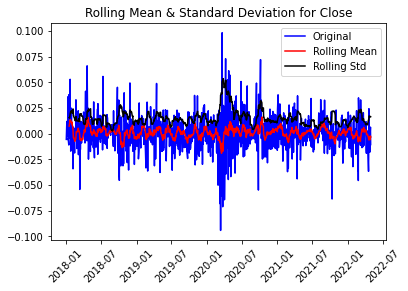

Results of Dickey-Fuller Test:
Test Statistic                -1.038938e+01
p-value                        2.039856e-18
# Lags Used                    1.000000e+01
Number of Observations Used    1.056000e+03
Critical Value (1%)           -3.436558e+00
Critical Value (5%)           -2.864281e+00
Critical Value (10%)          -2.568229e+00
dtype: float64


In [ ]:
test_stationarity(data, 'Close')

since p value is very small we can clearly say that our time series is staitonary

**ADDING LAG feature**

Now it's time to check and add lags as feature to our data.

lag feature are nothing but the values of observation from previous timestamp like in our case lag 1 means the values from previous date and lag of 2 means values from date before yesterday and so on



these feature will help our model to get insight from values of stock from past few days

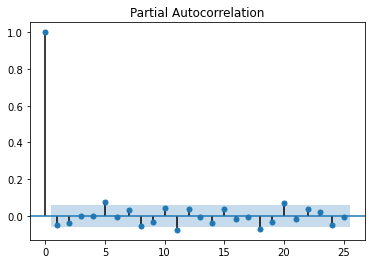

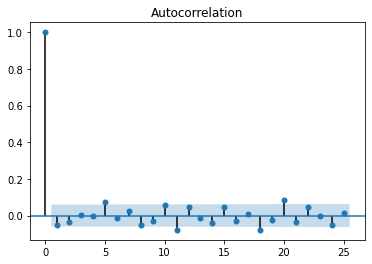

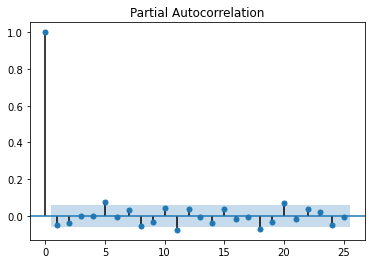

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.graphics.tsaplots as tsaplots

tsaplots.plot_acf(data['Close'].astype(float), lags=25)
tsaplots.plot_pacf(data['Close'].astype(float), lags=25)

as seen from the acf plot the data is very much correlated to previous day and this correlation decreases.


so we will use 10 lags for each variable in our data

In [ ]:
max_lags = 10

In [ ]:
for column in data.columns:
  for lag in range(1, max_lags+1):
    data[f'{column}Lag_{lag}'] = data[column].shift(lag)

In [ ]:

#dropping the NaN value rows 
#basically starting max_lags number of rows formed due to shifting

data.dropna(axis=0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1057 entries, 2018-01-16 to 2022-04-29
Data columns (total 66 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1057 non-null   float64
 1   High             1057 non-null   float64
 2   Low              1057 non-null   float64
 3   Close            1057 non-null   float64
 4   Adj Close        1057 non-null   float64
 5   Volume           1057 non-null   float64
 6   OpenLag_1        1057 non-null   float64
 7   OpenLag_2        1057 non-null   float64
 8   OpenLag_3        1057 non-null   float64
 9   OpenLag_4        1057 non-null   float64
 10  OpenLag_5        1057 non-null   float64
 11  OpenLag_6        1057 non-null   float64
 12  OpenLag_7        1057 non-null   float64
 13  OpenLag_8        1057 non-null   float64
 14  OpenLag_9        1057 non-null   float64
 15  OpenLag_10       1057 non-null   float64
 16  HighLag_1        1057 non-null   float64
 

Let's Normalize the data and rescale it to range [-1, 1]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data_norm = StandardScaler().fit_transform(data.values)
data_norm_scaled = MinMaxScaler(feature_range=(-1, 1)).fit_transform(data_norm)

In [ ]:
processed_data = pd.DataFrame(data_norm_scaled, columns=data.columns)
processed_data.head()

,Open,High,Low,Close,Adj Close,Volume,OpenLag_1,OpenLag_2,OpenLag_3,OpenLag_4,...,VolumeLag_1,VolumeLag_2,VolumeLag_3,VolumeLag_4,VolumeLag_5,VolumeLag_6,VolumeLag_7,VolumeLag_8,VolumeLag_9,VolumeLag_10
0,0.109239,-0.040679,0.164210,0.373623,0.373624,-0.862746,0.085007,0.170381,0.571589,0.173588,...,-0.981364,-0.938605,-0.966376,-0.927533,-0.919721,-0.950792,-0.941911,-0.967450,-0.970858,-0.934444
1,0.622361,-0.005546,0.436670,0.116234,0.116234,-0.954294,0.109239,0.085007,0.170381,0.571589,...,-0.862746,-0.981364,-0.938605,-0.966376,-0.927533,-0.919721,-0.950792,-0.941911,-0.967450,-0.970858
2,0.287578,-0.230408,0.136066,0.082586,0.082587,-0.977443,0.622361,0.109239,0.085007,0.170381,...,-0.954294,-0.862746,-0.981364,-0.938605,-0.966376,-0.927533,-0.919721,-0.950792,-0.941911,-0.967450
3,0.310346,-0.068489,0.216861,0.123709,0.123707,-0.962820,0.287578,0.622361,0.109239,0.085007,...,-0.977443,-0.954294,-0.862746,-0.981364,-0.938605,-0.966376,-0.927533,-0.919721,-0.950792,-0.941911
4,0.297875,0.331350,0.169303,0.528819,0.554754,-0.887905,0.310346,0.287578,0.622361,0.109239,...,-0.962820,-0.977443,-0.954294,-0.862746,-0.981364,-0.938605,-0.966376,-0.927533,-0.919721,-0.950792


**Breaking The data into train, cross validation and test set**

90% training data

10% = (40% testing data + 60% cross validation data)

In [ ]:
no_of_training_samples = round(90*(processed_data.shape[0]/100))
no_of_validation_samples = round(60*((processed_data.shape[0]-no_of_training_samples)/100))
no_of_test_samples = processed_data.shape[0]-no_of_training_samples - no_of_validation_samples

print(processed_data.shape[0], no_of_training_samples, no_of_validation_samples, no_of_test_samples)

1057 951 64 42


In [ ]:
X = processed_data[[col for col in processed_data.columns if col!='Close']]
y = processed_data[['Close']]
X.shape, y.shape

((1057, 65), (1057, 1))

In [ ]:
x_train, y_train = X.iloc[0:no_of_training_samples], y.iloc[0:no_of_training_samples]
x_train.shape, y_train.shape

((951, 65), (951, 1))

In [ ]:
x_val, y_val = X.iloc[no_of_training_samples:no_of_training_samples+no_of_validation_samples], y.iloc[no_of_training_samples:no_of_training_samples+no_of_validation_samples]
x_val.shape, y_val.shape

((64, 65), (64, 1))

In [ ]:
x_test, y_test = X.iloc[no_of_training_samples+no_of_validation_samples:], y.iloc[no_of_training_samples+no_of_validation_samples:]
x_test.shape, y_test.shape

((42, 65), (42, 1))

### Prediction using Fead Forward neural Network (FNN)

In [ ]:
#hyper parameters
input_dim=65   # how many Variables/features are in the dataset
hidden_dim1 = 30
hidden_dim2 = 10
#hidden_dim3 = 10
output_dim=1

lr = 0.01 #learing rate
num_epochs=100 #number of epochs
batch_size=50

In [ ]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [ ]:
class StockDataset(Dataset):
  def __init__(self, x, y):#x, y are pandas Dtaframe 
    self.x = df_to_tensor(x)
    self.y = df_to_tensor(y)

  def __getitem__(self, index):
    return self.x[index], self.y[index]
  
  def __len__(self):
    return self.x.shape[0]

In [ ]:
dataset = StockDataset(x_train, y_train)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Model, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Tanh(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Tanh(),
            nn.Linear(hidden_dim2, output_dim),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

In [ ]:
model = Model(input_dim,hidden_dim1,hidden_dim2,output_dim)
print(model.parameters)

<bound method Module.parameters of Model(
  (linear_stack): Sequential(
    (0): Linear(in_features=65, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)>


In [ ]:
loss_function = nn.MSELoss()
optimizer=torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
  for i, data in enumerate(data_loader, 0):
    inputs, value = data
    inputs, value = Variable(inputs), Variable(value)
    #print(inputs, value)
    value_pred = model(inputs)
    #print(value_pred)
    loss = loss_function(value_pred, value)
    # print(epoch, i, loss.data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
x_val = Variable(df_to_tensor(x_val))

In [ ]:
y_val_pred = model(x_val)
print(y_val_pred.flatten())

tensor([ 0.0087,  0.0320,  0.0426,  0.0017,  0.0416, -0.0211, -0.0901, -0.0098,
         0.0509, -0.0650,  0.0152,  0.0240, -0.0142, -0.0428,  0.0139, -0.0102,
        -0.0974,  0.0721, -0.0070,  0.0241,  0.0067, -0.0069,  0.0044, -0.0412,
         0.0087,  0.0086,  0.0362,  0.0615, -0.0248, -0.0555,  0.0358,  0.0744,
        -0.0704,  0.0035,  0.0153,  0.0518,  0.0590, -0.0183, -0.0934, -0.0667,
        -0.0265, -0.0774, -0.0171, -0.1206,  0.0250,  0.0715,  0.0157,  0.0523,
        -0.0674, -0.0693, -0.0386, -0.0733, -0.0369, -0.0105, -0.0529,  0.0446,
         0.0674, -0.0085, -0.0610, -0.0157, -0.0554, -0.2017, -0.0083, -0.2076],
       grad_fn=<ReshapeAliasBackward0>)


In [ ]:
x_val=np.arange(no_of_training_samples, no_of_training_samples+no_of_validation_samples)

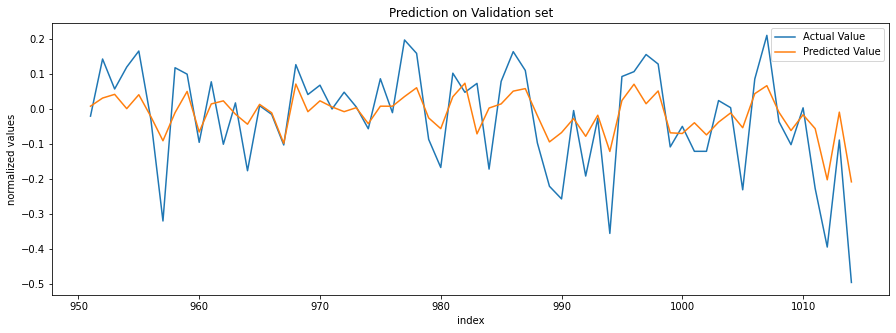

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(x_val, y_val);
plt.plot(x_val, y_val_pred.detach().numpy());
plt.legend(['Actual Value', 'Predicted Value'])
plt.title('Prediction on Validation set')
plt.xlabel('index')
plt.ylabel('normalized values');

In [ ]:
mean_squared_error(y_val, y_val_pred.detach().numpy())

0.010695028814331535

In [ ]:
x_test = Variable(df_to_tensor(x_test))

In [ ]:
y_test_pred = model(x_test)
print(y_test_pred.flatten())

tensor([ 0.1148, -0.0103,  0.0571, -0.0627, -0.0067, -0.0994,  0.0393,  0.0027,
        -0.0304, -0.0694,  0.0543, -0.0109,  0.0071,  0.0123, -0.0625,  0.0207,
         0.0778,  0.0126, -0.0681, -0.0401,  0.0316, -0.0180,  0.0230, -0.0088,
         0.0015,  0.0395, -0.0611, -0.0823, -0.0477,  0.0029, -0.0080, -0.0328,
        -0.1413, -0.0478,  0.0261,  0.0812, -0.0918, -0.0493, -0.0072, -0.0252,
        -0.0054, -0.0510], grad_fn=<ReshapeAliasBackward0>)


In [ ]:
x_test=np.arange(no_of_training_samples+no_of_validation_samples, processed_data.shape[0])

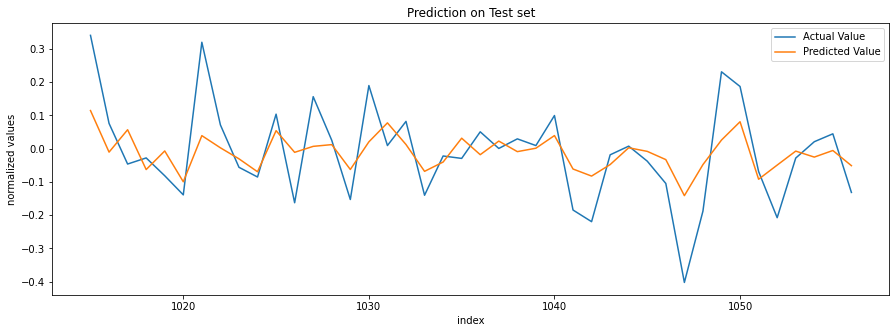

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(x_test, y_test);
plt.plot(x_test, y_test_pred.detach().numpy());
plt.legend(['Actual Value', 'Predicted Value'])
plt.title('Prediction on Test set')
plt.xlabel('index')
plt.ylabel('normalized values');

In [ ]:
mean_squared_error(y_test, y_test_pred.detach().numpy())

0.011798989589535801

### Prediction using Convolutional Neural Network (CNN)

since now we were looking at the values cross-sectionally what that means is that we were using features from yesterday topredict tomorrows prediction it doesn't take into account the data from day before yesterday or before , it has no idea how the market was behaving previously


but now we will be using a 30 days period where we will extract features from this time period and then use it to predict value for coming days

we can choose any number of days as our period


---


so now our data will be of type (number of training example) x (period=30) x (number of features)


Preparing the train test and validation data as per above discussion

In [ ]:
x_train, y_train = X.iloc[0:no_of_training_samples], y.iloc[0:no_of_training_samples]
print(x_train.shape, y_train.shape)

x_val, y_val = X.iloc[no_of_training_samples:no_of_training_samples+no_of_validation_samples], y.iloc[no_of_training_samples:no_of_training_samples+no_of_validation_samples]
print(x_val.shape, y_val.shape)

x_test, y_test = X.iloc[no_of_training_samples+no_of_validation_samples:], y.iloc[no_of_training_samples+no_of_validation_samples:]
print(x_test.shape, y_test.shape)

(951, 65) (951, 1)
(64, 65) (64, 1)
(42, 65) (42, 1)


In [ ]:
period = 30

In [ ]:
#this is the function which will split our dataset such that each example will be a stack of period number of previous observations
#here n_steps variable of function refers to as period in our discussion
#source of this snippet-> https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequence(sequence, n_steps):
	X = list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x = sequence[i:end_ix]
		X.append(seq_x)
	return array(X)

In [ ]:
x_train_cnn, y_train_cnn = split_sequence(x_train, period), y_train[0:y_train.shape[0]-period]
x_train.shape, x_train_cnn.shape, y_train_cnn.shape

((951, 65), (921, 30, 65), (921, 1))

In [ ]:
x_val_cnn, y_val_cnn = split_sequence(x_val, period), y_val[0:y_val.shape[0]-period]
x_val.shape, x_val_cnn.shape, y_val_cnn.shape

((64, 65), (34, 30, 65), (34, 1))

In [ ]:
x_test_cnn, y_test_cnn = split_sequence(x_test, period), y_test[0:y_test.shape[0]-period]
x_test.shape, x_test_cnn.shape, y_test_cnn.shape

((42, 65), (12, 30, 65), (12, 1))

Building a CNN model using Keras

In [ ]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout, AveragePooling1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from keras.layers.normalization import batch_normalization
from keras.regularizers import l1, l2, l1_l2

In [ ]:
############################################################
#setting the seed for random so that weights are same for each time i run the model
np.random.seed(21)
rn.seed(12345)
tf.random.set_seed(1234)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
############################ Building model ################

#setting up the early stopping criteria
#based on the mse loss on cross validation set
#EarlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)

#setting the number of epochs, batchsize, learning rate
epochs = 1000
bs = 20
lr = 0.001

#number of features
n_features = x_train_cnn.shape[2]

#making a keras sequential model
model = Sequential()

model.add(Conv1D(filters=5,
                 kernel_size=2,
                 strides=2,
                 activation='linear',
                 input_shape = (period, n_features)))#input shape is the shape of 1 sample

model.add(MaxPooling1D(pool_size=1)) #simply using all samples

model.add(Dropout(0.1)) #dropping some random weights to reduce overfitting

model.add(Flatten()) #flattening the bs x 15 x 5 layer into bs x 75 layer

model.add(Dense(1,#number of output
                activation='tanh',
                kernel_regularizer=l2(0.01)))

model.compile(loss='mean_squared_error', optimizer='sgd')

#model summary
model.summary()

###### Training the Model #####
model.fit(x_train_cnn, y_train_cnn,
          batch_size=bs,
          epochs=epochs,
          #callbacks = [EarlyStop],
          verbose=2,
          shuffle=False,
          validation_data = (x_val_cnn, y_val_cnn))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 5)             655       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 5)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 5)             0         
                                                                 
 flatten (Flatten)           (None, 75)                0         
                                                                 
 dense (Dense)               (None, 1)                 76        
                                                                 
Total params: 731
Trainable params: 731
Non-trainable params: 0
__________________________________________________________

In [ ]:
y_val_cnn_pred = model.predict(x_val_cnn)
type(y_val_cnn_pred), y_val_cnn_pred.shape

(numpy.ndarray, (34, 1))

In [ ]:
x_cnn_val = np.arange(y_val_cnn.shape[0])
x_cnn_val

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

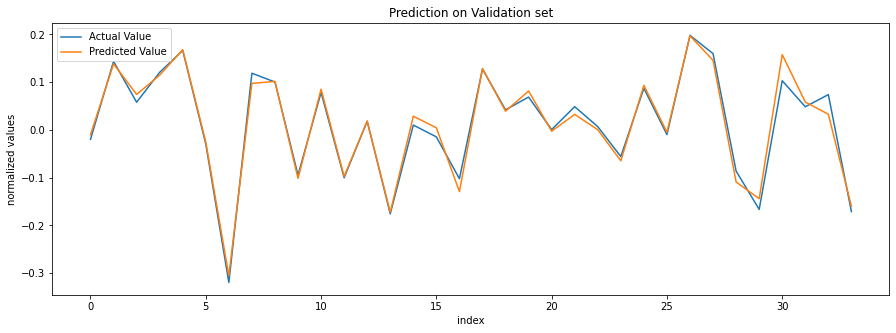

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(x_cnn_val, y_val_cnn);
plt.plot(x_cnn_val, y_val_cnn_pred);
plt.legend(['Actual Value', 'Predicted Value'])
plt.title('Prediction on Validation set')
plt.xlabel('index')
plt.ylabel('normalized values');

In [ ]:
mean_squared_error(y_val_cnn, y_val_cnn_pred)

0.0002761477009136897

Performance on test set

In [ ]:
y_test_cnn_pred = model.predict(x_test_cnn)
type(y_test_cnn_pred), y_test_cnn_pred.shape

(numpy.ndarray, (12, 1))

In [ ]:
x_cnn_test = np.arange(y_test_cnn.shape[0])
x_cnn_test

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

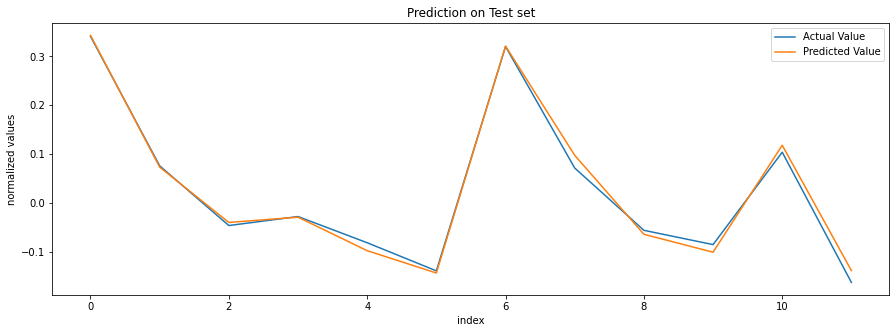

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(x_cnn_test, y_test_cnn);
plt.plot(x_cnn_test, y_test_cnn_pred);
plt.legend(['Actual Value', 'Predicted Value'])
plt.title('Prediction on Test set')
plt.xlabel('index')
plt.ylabel('normalized values');

In [ ]:
mean_squared_error(y_test_cnn, y_test_cnn_pred)

0.00017609081942614242